In [185]:
import numpy as np
import matplotlib.pyplot as plt
import random


## Task 1 (3 points)

Consider the following toy dataset:

Implement a linear model $\hat y(x|w) = w_1\cdot x + w_0$ with MAE loss:
$$\text{MAE}(w) = \frac{1}{N}\sum_{i=1}^N\left|y_i - \hat y(x_i|w)\right|,$$
using gradient descent optimization in `numpy`.

*Hint: introduce a constant feature to account for the bias term to make the formulas simpler.*

Plot the learning curve and the final fit. Also, fit the same data with `sklearn`'s `LinearRegression`, and compare the two fits on the same plot. What do you observe? Write a short comment.

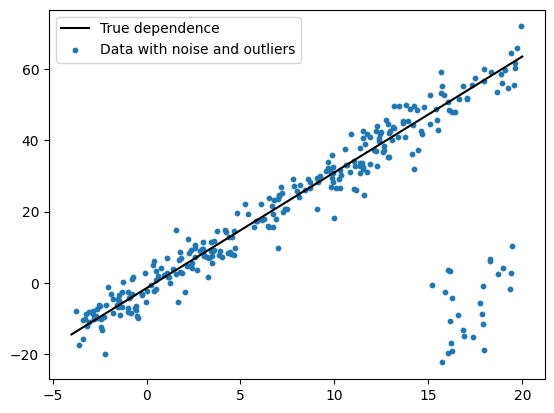

In [186]:
true_function = lambda x: 3.25 * x - 1.47
noize_function = lambda x: (
    np.random.normal(size=len(x)) * 4. +
    np.where(
        x < 15,
        0.,
        -60 + np.random.normal(size=len(x)) * 10
    ) * (np.random.uniform(size=len(x)) < 0.4).astype(int)
)
limits = (-4., 20.)

def generate_dataset(N=300):
  x = np.random.uniform(*limits, size=N)
  y = true_function(x) + noize_function(x)

  return x[:,None], y

X, y = generate_dataset()

x = np.linspace(*limits, 101)
plt.plot(x, true_function(x), c='black', label='True dependence')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.legend();

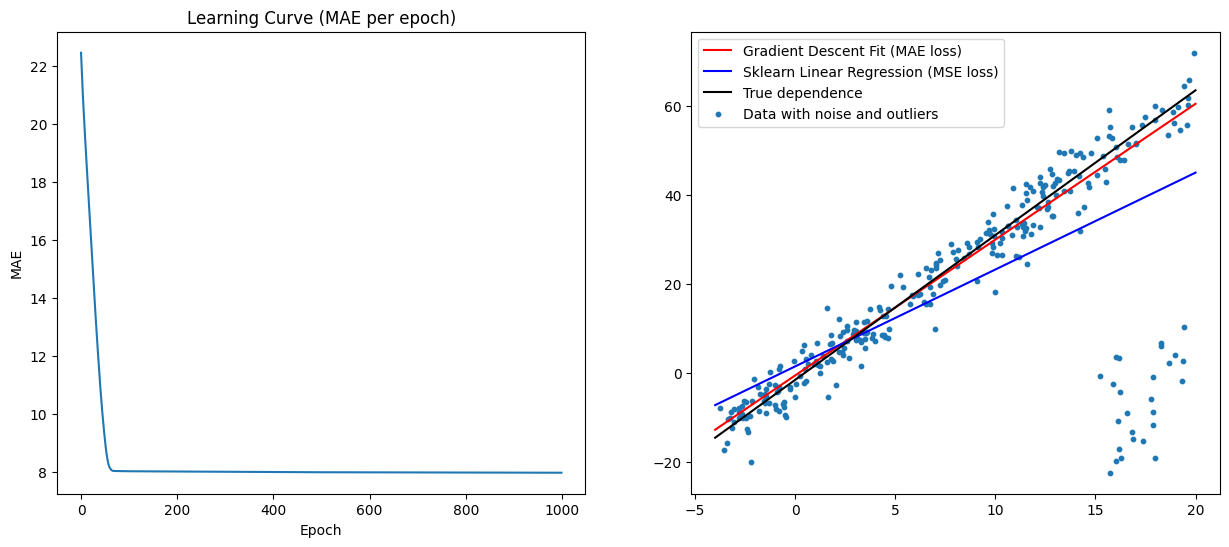

In [187]:
from sklearn.linear_model import LinearRegression
# Gradient Descent Implementation for MAE loss
def gradient_descent(X, y, lr=0.01, epochs=1000):
    N = len(y)
    w = np.zeros(2)  # Initialize weights [w_0, w_1]
    history = []  # To store MAE for plotting

    for epoch in range(epochs):
        y_pred = w[1] * X[:, 0] + w[0]
        error = y - y_pred

        grad_w1 = -np.mean(np.sign(error) * X[:, 0])
        grad_w0 = -np.mean(np.sign(error))

        w[1] -= lr * grad_w1
        w[0] -= lr * grad_w0

        mae = np.mean(np.abs(error))
        history.append(mae)

    return w, history

w, history = gradient_descent(X, y)



plt.figure(figsize=(15,6))


# Plotting the learning curve
plt.subplot(1,2,1)
plt.plot(history)
plt.title("Learning Curve (MAE per epoch)")
plt.xlabel("Epoch")
plt.ylabel("MAE")


# Plotting the final fit
plt.subplot(1,2,2)
x_range = np.linspace(*limits, 101)
plt.plot(x_range, w[1] * x_range + w[0], label="Gradient Descent Fit (MAE loss)", c='red')
model = LinearRegression()
model.fit(X, y)
plt.plot(x_range, model.coef_ * x_range + model.intercept_, label="Sklearn Linear Regression (MSE loss)", c='blue')
plt.plot(x_range, true_function(x_range), c='black', label='True dependence')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.legend()
plt.show()



##Comment

From this final plot, we can infer several points:

- The MAE loss decreases rapidly during the initial epochs of training, suggesting that the model is quickly adjusting its parameters in response to the data.

- As the number of epochs increases, the decrease in MAE slows down, indicating that the model is converging to an optimal set of parameters.

- The model trained with the MAE loss (red line) appears more robust to outliers. This is evident from the fact that despite significant noise and some extreme outliers, especially in the right part of the plot, the red line stays closer to the "True dependence" (black line).
- The model trained with sklearn's `LinearRegression` (blue line) that minimizes MSE is more sensitive to outliers. This is particularly clear around the x-values of 15 to 20, where the blue line is pulled upwards due to the influence of the outliers. MSE gives more weight to larger errors (because they're squared), which means outliers can have a significant impact on the fit.
- Overall, the gradient descent with MAE seems to provide a fit that's more representative of the underlying true function in the presence of outliers.




## Task 2 (2 + 1 points)

* Wrap your solution from the previous task into a class. Plot the learning curve and the final fit. Compare and comment your results with the previos ones. **(2 points)**

* Make it possible to choose a loss function. **(1 point)**

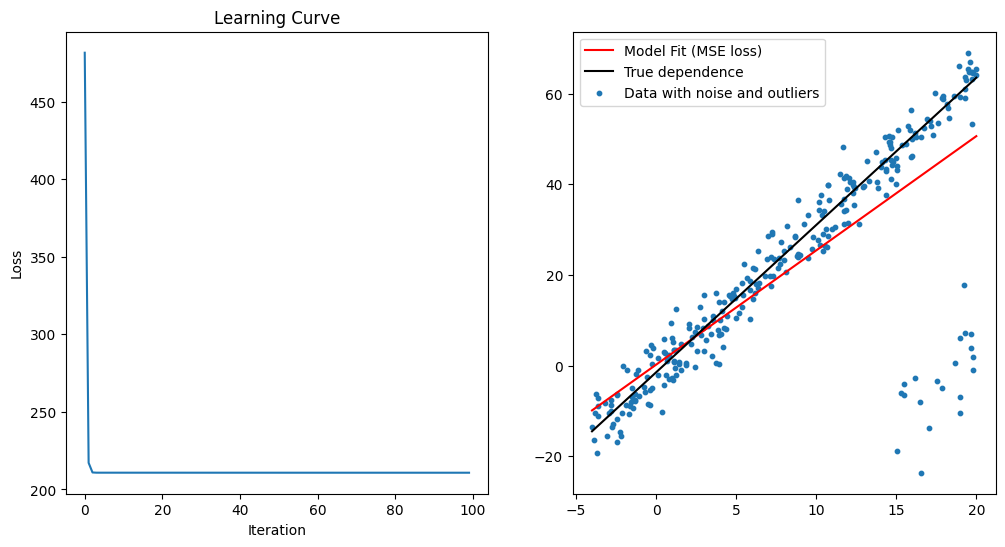

In [192]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin

class LinearRegressionSGD(BaseEstimator, RegressorMixin):
    def __init__(self, loss="MAE"):
        self.w = np.array([1, 0])
        self.loss_type = loss
        self.losses = []

    def loss_func(self, y, p):
        if self.loss_type == "MAE":
            return np.sum(np.abs(y - p)) / len(y)
        elif self.loss_type == "MSE":
            return np.mean((y - p) ** 2)

    def fit(self, X, y, num_iter=100, lr=0.1):
        for i in range(num_iter):
            self.losses.append(self.loss_func(y, X @ self.w))
            if self.loss_type == "MAE":
                grad = np.sign(X @ self.w - y).mean()
            elif self.loss_type == "MSE":
                grad = X.T @ (X @ self.w - y) / len(y)
            self.w = self.w - lr * grad

    def predict(self, X):
        return X @ self.w

    def fit_predict(self, X, y, num_iter=100, lr=0.1):
        for i in range(num_iter):
            self.losses.append(self.loss_func(y, X @ self.w))
            if self.loss_type == "MAE":
                grad = np.sign(X @ self.w - y).mean()
            elif self.loss_type == "MSE":
                grad = X.T @ (X @ self.w - y) / len(y)
            self.w = self.w - lr * grad
        return X @ self.w

# Choose the loss function between MSE and MAE
X, y = generate_dataset()
model = LinearRegressionSGD(loss="MSE")
X = np.c_[X, np.ones(X.shape[0])]

if model.loss_type =="MSE":
  # Fit the model using the provided dataset with a smaller learning rate
  model.fit(X, y, lr=0.01)

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(model.losses, label="Learning Curve (MSE loss)")
  plt.title("Learning Curve")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.subplot(1, 2, 2)
  x_range = np.linspace(*limits, 101)
  x_range_reshaped = np.c_[x_range, np.ones(x_range.shape[0])]
  plt.plot(x_range, model.predict(x_range_reshaped), label="Model Fit (MSE loss)", c="red")
  plt.plot(x_range, true_function(x_range), c="black", label="True dependence")
  plt.scatter(X[:, 0], y, s=10, label="Data with noise and outliers")
  plt.legend()
  plt.show()

else:
  model.fit(X, y)
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(model.losses, label="Learning Curve (MAE loss)")
  plt.title("Learning Curve")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.subplot(1, 2, 2)
  x_range = np.linspace(*limits, 101)
  x_range_reshaped = np.c_[x_range, np.ones(x_range.shape[0])]
  plt.plot(x_range, model.predict(x_range_reshaped), label="Model Fit (MAE loss)", c="green")
  plt.plot(x_range, true_function(x_range), c="black", label="True dependence")
  plt.scatter(X[:, 0], y, s=10, label="Data with noise and outliers")
  plt.legend()

  plt.show()

##Comment
- Adjusting the `learning_rate_mse` and `n_epochs_mse` values can help achieve better convergence and a better fit.
- Just like the task 1, `mse` is tilted towards the outliers unlike `mae`
- From the above plots we can find that `mse` converges very fast as compared to `mae`
